<a href="https://colab.research.google.com/github/hecmaruwu/Ejemplo_Repositorio-MDS/blob/main/Tarea_5_avance_H_problema_painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 5: Modelos de difusión

### MDS7203 Modelos Generativos Profundos

**Nombre:**

**Fecha de entrega:**

En esta quinta tarea se evaluarán los contenidos asociados a modelos de difusión. Para esto, se implementarán algunas funciones asociadas al modelo Stable Diffusion.

Algunas instrucciones generales:

- Se pueden utilizar de manera libre herramientas como ChatGPT y Claude, entre otras.
- Para la entrega, no es necesario un informe, este archivo es suficiente.
- Se debe entregar el documento con todas las celdas ejecutadas.
- Esta tarea debe ser resuelta utilizando Google Colab.
- La tarea está compuesta por tres partes. Todas las partes valen lo mismo.

In [1]:
import requests
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms, utils
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
import random
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Parte 1: Modelo Stable Diffusion

En esta primera parte se cargará el modelo Stable Diffusion 1.4 y se revisarán sus componentes.

In [3]:
model_id = "CompVis/stable-diffusion-v1-4"

tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder").to(device)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae").to(device)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

- Implemente la función `count_parameters` para contar la cantidad de parámetros de los modelos anteriores.

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"CLIP Text Encoder: {count_parameters(text_encoder)} parámetros.")
print(f"VAE: {count_parameters(vae)} parámetros.")
print(f"U-Net: {count_parameters(unet)} parámetros.")

CLIP Text Encoder: 123060480 parámetros.
VAE: 83653863 parámetros.
U-Net: 859520964 parámetros.


In [5]:
prompt = 'perrito sentado'
text_input = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True)
text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [6]:
print(text_input)
print(text_input['input_ids'])
print('dimension text_input: ', text_input['input_ids'].shape)
print('dimension text_embeddings: ', text_embeddings.shape)


{'input_ids': tensor([[49406,   703, 19379,  6200,  2933, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
tensor([[49406,   703, 19379,  6200,  2933, 49407]])
dimension text_input:  torch.Size([1, 6])
dimension text_embeddings:  torch.Size([1, 6, 768])


### CLIP Text encoder

El tokenizador y el embedding de texto pueden usarse de la siguiente forma:

```
prompt = <texto para guiar la generación>
text_input = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True)
text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
```

- ¿Qué tokenizador utiliza el modelo CLIP?
> **Respuesta:**
El  tkenizador de CLIP está basado en un Byte-Pair-Encoder (BPE), el mismo que utiliza GPT-2. Este tokeniza a partir de "subpalabras", formadas a partir de divisiones de la palabras por sílabas o unidades más pequeñas.

- ¿Qué elementos contiene el objeto `text_input`?
> **Respuesta:**
`text_input` es un diccionario que contiene `ìnput_ids`, es decir los ID de los tokens generados, y `attention_mask` un vector quee tiene el valor 1 si al token en esa posición se le debe poner atención, 0 en caso contrario.

- ¿Cuál es la dimensión del tensor `text_input["input_ids"]`? ¿Qué indica este valor?
> **Respuesta:**
Es un tensor de dim (1,6), esto quiere decir que se generan oraciones con 6 tokens, donde el primero y último de estos son tokens especiales para denotar el inicio y final de la oración.

- ¿Cuál es la dimensión de embedding del modelo CLIP?
> **Respuesta:**
Según `text_embeddings` (revisado arriba), este tiene dimensión 768.

- ¿Cuál es la diferencia entre usar un embedding tipo CLIP y un embedding tipo BERT?
> **Respuesta:**
Usar un embedding de tipo BERT permite captar el significado y contexto de un texto, por lo que es muy útil para la predcicción de palabras. Mientras que CLIP permite relacionar texto con su imagen correspondiente

- Implemente la función `cosine_similarity` para evaluar la similitud de dos cadenas de texto a partir de sus embeddings generados por el modelo CLIP.





In [7]:
def cosine_similarity(p1, p2, tokenizer, encoder):
  input_1 = tokenizer([p1], return_tensors="pt", padding=True, truncation=True).to(device)
  input_2 = tokenizer([p2], return_tensors="pt", padding=True, truncation=True).to(device)

  with torch.no_grad():
    out1 = encoder(**input_1)
    out2 = encoder(**input_2)

    # Calculamos out2.pooler_output[0], que corresponde al vector de embedding para
    # la oracion tokenizada, no se puede usar solo encoder(**input2) porque también
    # entrega un tensor con los embeddings de cada token.
    emb_1 = out1.pooler_output[0]
    emb_2 = out2.pooler_output[0]

    norm_1 = torch.norm(emb_1)
    norm_2 = torch.norm(emb_2)

  # Similitud coseno: a*b/( ||a||*||b||)
  return torch.dot(emb_1, emb_2)/(norm_1 * norm_2)

# Prompts:
prompt_a = "A photo of a red sports car driving on a mountain road"
prompt_b = "A photograph of a luxury car speeding on a hill highway"
prompt_c = "A portrait of a medieval queen in oil painting style"

# Similitud:
sim_ab = cosine_similarity(prompt_a, prompt_b, tokenizer, text_encoder)
sim_ac = cosine_similarity(prompt_a, prompt_c, tokenizer, text_encoder)
sim_bc = cosine_similarity(prompt_b, prompt_c, tokenizer, text_encoder)

print(f"Similitud(a, b): {sim_ab:.4f}")
print(f"Similitud(a, c): {sim_ac:.4f}")
print(f"Similitud(b, c): {sim_bc:.4f}")

Similitud(a, b): 0.6739
Similitud(a, c): 0.1487
Similitud(b, c): 0.1718


### VAE

El modelo Stable Diffusion realiza el proceso de difusión en el espacio latente de un VAE. El siguiente código muestra como utilizar este VAE, el cual espera recibir una imagen de tamaño $512\times512\times3$:


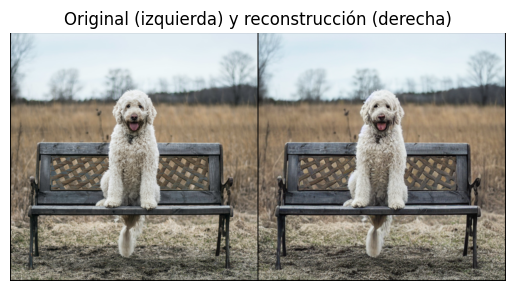

In [8]:
def load_image_from_url(url, size=(512, 512), mode="RGB"):
    img = Image.open(requests.get(url, stream=True).raw).convert(mode)
    img = img.resize(size, Image.BICUBIC)
    return img

def preprocess(img_pil):
    to_tensor = transforms.ToTensor()
    x = to_tensor(img_pil).unsqueeze(0).to(device)
    return 2.0 * x - 1.0

# Ejemplo:
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
img_pil = load_image_from_url(image_url)
x = preprocess(img_pil)

# Reconstrucción:
with torch.no_grad():
    z = vae.encode(x).latent_dist.sample()
    x_rec = vae.decode(z).sample
    x_rec = (x_rec.clamp(-1, 1) + 1) / 2

# Visualización:
grid = utils.make_grid(torch.cat([x.clamp(-1,1).add(1).div(2), x_rec], dim=0), nrow=2)
plt.imshow(grid.cpu().permute(1, 2, 0))
plt.axis("off")
plt.title("Original (izquierda) y reconstrucción (derecha)")
plt.show()

- ¿Qué normalización se le realiza a la imagen antes de entrar al VAE?
> **Respuesta:**
Primero se transforma en un tensor (porque asi se paraleliza más fácil con la GPU) y posteriormente se normaliza entre [-1,1] , esto debido a que arquitecturas modernas de VAE usan la función Tanh que tiene recorrido entre -1 y 1 y esta centrada en 0, lo que mejora el training (más estabilidad)

- ¿Cuál es la dimensión latente asociada a este VAE?
> **Respuesta:**
Según lo que encontré en la documentación https://huggingface.co/docs/diffusers/en/api/models/autoencoderkl
 las dimensiones latentes son 4
latent_channels (int, optional, defaults to 4) — Number of channels in the latent space.
Además, el encoder del VAE reduce la imagen en altura y ancho por un factor de 8 poruqe son por capas con stride=2 aplicadas 3 veces
Así que si partes con una imagen de 512×512, al pasar por el encoder se convierte en una dimensión latente de la forma [batch,4,64,64]

#### U-Net

Para el proceso de denoising, el modelo de difusión utiliza una arquitectura tipo U-Net. En el siguiente código se verificará que la dimensión de salida corresponde con lo que se espera obtener.

- Asigne los valores a las variables `latent_channels` (canales de la variable latente), `height` y `width` (resolución de la variable latente), y `context_dim` (dimensión del embedding de CLIP).

In [9]:
torch.cuda.empty_cache()

In [10]:
batch_size = 1
latent_channels = 4
height = width = 128
context_dim = 768

# Tensores aleatorios:
z_t = torch.randn(batch_size, latent_channels, height, width).to(device)
t = torch.tensor([50]).to(device)
context = torch.randn(batch_size, 77, context_dim).to(device)

# Forward:
with torch.no_grad():
    output = unet(z_t, t, encoder_hidden_states=context)

assert output["sample"].shape == (batch_size, latent_channels, height, width)

- ¿Cómo es inyectado el tensor `context` en la arquitectura U-Net usada en Stable Diffusion?
> **Respuesta:**
El tensor context se pasa como un encoderhidden_states a la arquitectura U-net de stablle diffusion,siendo una representación de los embeddings de texto que se generaron  con el modelo CLIP, además toma batches de 77 (por la cantidad de tokens que genera CLIP) y cada uno de esos tiene el tamaño  que se le dio al context_dim, osea 768, entonces la dimensión de un batch sería de  [1,77,768]
Dentro de la U-net el contex se inyecta en bloques de cross-attention que se distribuyen en distintas etapas, las del encoder, decoder y el bloque intermedio, de esa forma la U-net ajustada puede comprender el texto relacionado a cada imagen y generar imágenes que respeten el contenido del promt
- ¿Qué diferencia la arquitectura DiT de la arquitectura U-Net?
> **Respuesta:**
La diferencia de arquitectura radica en que la arquitecutura DiT cambia toda la arquitectura convolucional de la U-Net clásica por una arquitectura que se basa en bloques Transformer, osea en vez de hacer saltos (skip-connections) como en la Unet tradicional, Dit utiliza tanto sel-attention como cross-attention en todas las capas, lo que permite generalizar mejor y también que el modelo comprenda relaciones locales entre imagenes y texto.
Entonces Dit es más flexible y a la vez escala mejor por la naturaleza de capturar relaciones complejas con la atención

Creo que con la arquitectura que me dio GPT se entiende mejor:

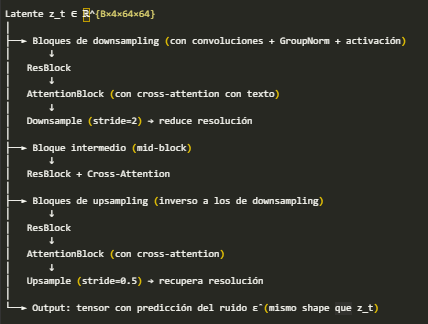

## Parte 2: Denoising

En esta segunda parte se implementará el proceso de denoising utilizando Stable Diffusion. Dado que este modelo es condicional, se realizará una generación condicional simple y luego una generación condicional utilizando classifier-free guidance.

#### DDIM Scheduler

Una de las principales limitaciones de los modelos de difusión es que el proceso reverso es costoso ya que se debe evaluar la red neuronal en cada tiempo de denoising. Una técnica que permite aminorar este problema es DDIM, la cual permite disminuir significativamente la cantidad de steps utilizados en el proceso reverso.

- Averigüe sobre el sampling realizado por DDIM y las diferencias que tiene con el enfoque DDPM estándar.
> **Respuesta:**
<!-- El DDIM aprovecha que los modelos implíticos no requieren de una expresión matemática explícita, sino que es el modelo el que define un conjunto de relaciones entre inputs y outputs sin especificarla. -->
En DDPM, el muestro se realiza mediante una cadena de Markov donde en cada paso se introduce ruido gaussiano. Su fómula de muestreo se basa en una dist condicional al paso anterior. Mientras que en DDIM, ya no se utilizan cadenas de Markov, aprovechando la ventaja de los Implicit Models. En este caso el muestreo deja de ser estocástico y puede ser determinista, ya que es capaz de saltar pasos en el proceso inverso (haciéndolo más rápido). Además, posee un parámetro $\eta$ que control que controla el ruido, si este se fija en 0 entonces ya no se incorpora ruido en cada paso, mientras que si es 1 entonces el modelo se parecerá a un DDPM.

In [11]:
n_steps = 50
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
scheduler.set_timesteps(n_steps, device=device)

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

#### Generación condicional simple

La siguiente función aplica el módulo de decoding de un VAE para una variable latente generada por el modelo de difusión:

In [12]:
def vae_decode(latents, plot_title):

    with torch.no_grad():
        latents_scaled = latents / vae.config.scaling_factor
        image = vae.decode(latents_scaled).sample
        image = (image.clamp(-1, 1) + 1) / 2

        grid = utils.make_grid(image, nrow=1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.axis("off")
        plt.title(plot_title)
        plt.show()

El modelo Stable Diffusion permite realizar generación condicional mediante la inyección de un texto (prompt) a la U-Net durante el proceso de denoising.

- Implemente la función `generate_sample`, la cual recibe una cadena de texto (`prompt`) y genera una nueva imagen utilizando la U-Net y el VAE estudiados en la primera parte. Visualice el proceso de denoising cada 10 iteraciones.

In [13]:
scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.34.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [55]:
def generate_sample(prompt):
    global tokenizer, scheduler, text_encoder, unet, vae_decode, context

    # tokenizar el texto
    tokens = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    # obtener el embedding del texto (sin gradientes)
    with torch.no_grad():
        text_embedding = text_encoder(tokens)[0]  # [1, 77, 768]

    # inicializar latente aleatorio (ruido inicial)
    z_t = torch.randn(batch_size, latent_channels, height, width).to(device)
    z_t = z_t * scheduler.init_noise_sigma  # escalar por sigma inicial del scheduler

    # loop de denoising
    for paso, t in enumerate(scheduler.timesteps):
        # predecir ruido con la unet
        with torch.no_grad():
            ruido_predicho = unet(z_t, t.to(device), encoder_hidden_states=text_embedding)['sample']

        # update del latente (FIX del orden de argumentos)
        z_t = scheduler.step(model_output=ruido_predicho.to(device), timestep=t, sample=z_t).prev_sample

        # visualizar cada 10 pasos
        if (paso + 1) % 10 == 0:
            with torch.no_grad():
                decoded = vae_decode(z_t, f"Step {paso+1}/{len(scheduler.timesteps)}")

        torch.cuda.empty_cache()


In [14]:
def generate_sample(prompt):
    global tokenizer, scheduler, text_encoder, unet, vae_decode, context
    # Llamo a los modelos y objetos que ya existen
    tokens = tokenizer([prompt], return_tensors="pt", padding=True, truncation=True).input_ids.to(device)

    with torch.no_grad():
        text_embedding = text_encoder(tokens)[0]

    # Inicializa ruido aleatorio latente
    # Agregamos la estructura tipo UNet para introducir ruido
    z = torch.randn(batch_size, latent_channels, height, width).to(device)

    # Scheduler ya tiene previamente cargado el número de pasos de inferencia
    z_t = z * scheduler.init_noise_sigma

    for step, t in enumerate(scheduler.timesteps):
        # Predicción del ruido con la UNet
        with torch.no_grad():
            ruido_predicho = unet(z_t, t.to(device), encoder_hidden_states=text_embedding)['sample']

        # Actualización de la variable latente
        z_t = scheduler.step(ruido_predicho.to(device), t.item(), z_t).prev_sample  # ← aquí está el fix importante

        # Visualización de imagen cada 10 pasos
        if (step+1) % 10 == 0:
            with torch.no_grad():
                decoded = vae_decode(z_t, f"Step {step+1}/50")  # vae_decode genera las imágenes

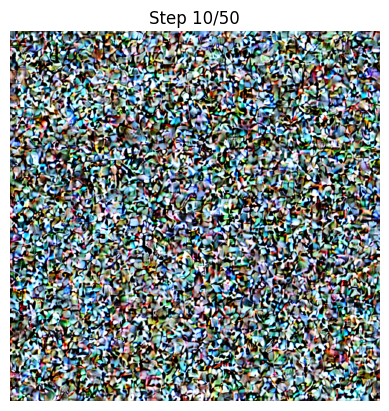

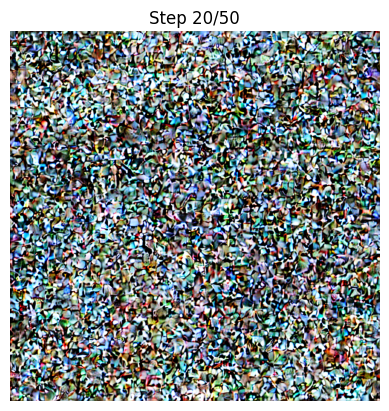

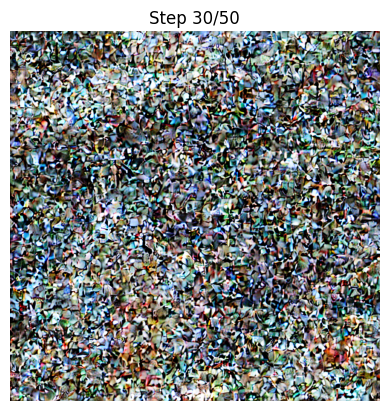

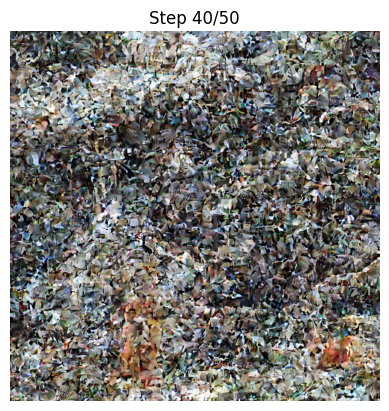

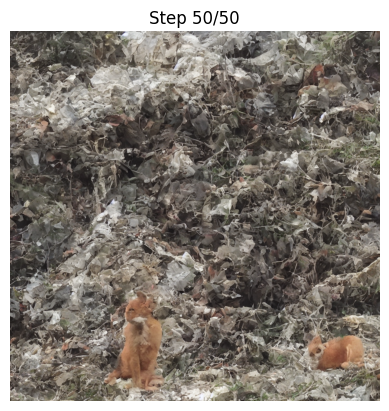

In [56]:
prompt = "A orange cat sitting on a park bench"
generate_sample(prompt)

#### Condicionamiento y guidance

Como se vio en clases, el condicionamiento simple no siempre permite generar muestras consistentes con el prompt. Una posible solución a este problema es utilizar la técnica de classifier-free guidance, la cual direcciona el ruido predicho en cada iteración para que la muestra final esté más ajustada al prompt.

- Implemente la función `generate_sample_guidance` para incluir el proceso de classifier-free guidance en la generación.

In [16]:
import torch
torch.cuda.empty_cache()

In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [39]:
# Preparar scheduler (esto va fuera de la función y se corre solo una vez)
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [40]:
scheduler.set_timesteps(50)  # 50 pasos de denoising, valor típico

# Codigo que corre bien dentro de todo

In [47]:
import torch
import gc
from diffusers import DDIMScheduler

# cargar scheduler
scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
scheduler.set_timesteps(50)  # pasos de denoising

def generate_sample_guidance(prompt, guidance):
    # obtener embeddings del texto y del vacío
    with torch.no_grad():
        entrada_texto = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
        contexto_texto = text_encoder(**entrada_texto).last_hidden_state

        entrada_vacia = tokenizer([""], padding="max_length", max_length=77, return_tensors="pt").to(device)
        contexto_vacio = text_encoder(**entrada_vacia).last_hidden_state

    contexto = torch.cat([contexto_vacio, contexto_texto], dim=0)  # [2,77,768]

    # ruido inicial
    latente = torch.randn(1, 4, 64, 64).to(device)

    for paso in scheduler.timesteps:
        entrada_latente = torch.cat([latente] * 2)
        with torch.no_grad():
            ruido_predicho = unet(entrada_latente, paso, encoder_hidden_states=contexto).sample

        ruido_vacio, ruido_texto = ruido_predicho.chunk(2)
        ruido_guiado = ruido_vacio + guidance * (ruido_texto - ruido_vacio)

        latente = scheduler.step(ruido_guiado, paso.item(), latente).prev_sample

    # decodificar imagen final
    with torch.no_grad():
        imagen = vae.decode(latente / 0.18215).sample
        imagen = (imagen.clamp(-1, 1) + 1) / 2

    # liberar memoria
    gc.collect()
    torch.cuda.empty_cache()

    return imagen

## Guidance scale 15

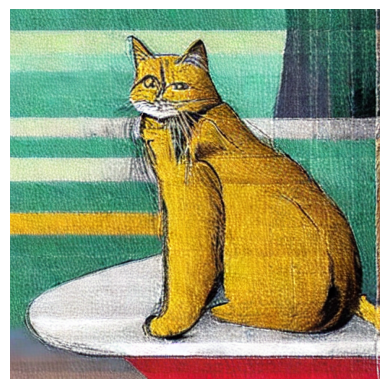

In [48]:
imagen =generate_sample_guidance("A yellow cat sitting on a park bench",15)

# convertir a formato visible por matplotlib
imagen_np = imagen[0].permute(1, 2, 0).cpu().numpy()

plt.imshow(imagen_np)
plt.axis("off")
plt.show()


In [49]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()

## Guidance scale 40

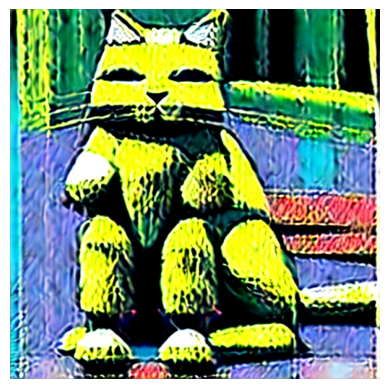

In [50]:
imagen =generate_sample_guidance("A yellow cat sitting on a park bench",40)

# convertir a formato visible por matplotlib
imagen_np = imagen[0].permute(1, 2, 0).cpu().numpy()

plt.imshow(imagen_np)
plt.axis("off")
plt.show()

## Guidance scale 100

In [51]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()

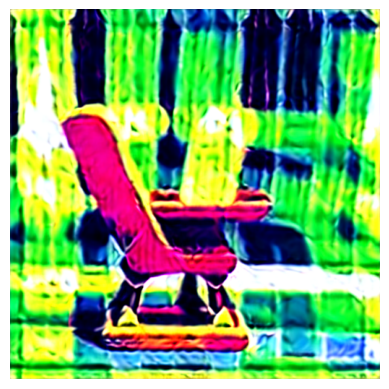

In [52]:
imagen =generate_sample_guidance("A yellow cat sitting on a park bench",100)

# convertir a formato visible por matplotlib
imagen_np = imagen[0].permute(1, 2, 0).cpu().numpy()

plt.imshow(imagen_np)
plt.axis("off")
plt.show()

## Guidance scale 1

In [53]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()

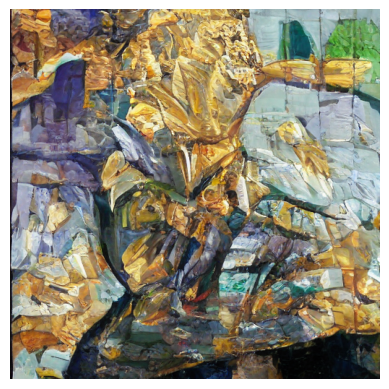

In [54]:
imagen =generate_sample_guidance("A yellow cat sitting on a park bench",1)

# convertir a formato visible por matplotlib
imagen_np = imagen[0].permute(1, 2, 0).cpu().numpy()

plt.imshow(imagen_np)
plt.axis("off")
plt.show()

# ESTE CÓDIGO ME FUNCIONO

In [28]:
import gc
import torch

def generate_sample_guidance(prompt, guidance_scale=1):
    # 1. Preparar el texto condicional y no condicional (sin cálculo de gradientes)
    with torch.no_grad():
        text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
        context_text = text_encoder(**text_input).last_hidden_state

        null_input = tokenizer([""], padding="max_length", max_length=77, return_tensors="pt").to(device)
        context_null = text_encoder(**null_input).last_hidden_state

    # 2. Concatenar el contexto condicional y no condicional
    context = torch.cat([context_null, context_text], dim=0)  # [2,77,768]

    # 3. Inicializar latente (ruido inicial)
    latents = torch.randn(1, 4, 128, 128).to(device)
    scheduler.set_timesteps(35)

    # 4. Iterar sobre los pasos de denoising
    for t in scheduler.timesteps:
        latent_input = torch.cat([latents] * 2)

        with torch.no_grad():
            # Predecir ruido para ambos contextos
            noise_pred = unet(latent_input, t, encoder_hidden_states=context).sample  # [2,4,32,32]

        # Separar ruido no condicional y condicional
        noise_uncond, noise_text = noise_pred.chunk(2)

        # 5. Aplicar Classifier-Free Guidance
        guided_noise = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        # 6. Paso del scheduler
        latents = scheduler.step(guided_noise, t.item(), latents).prev_sample

    # 7. Decodificar imagen sin cálculo de gradientes
    with torch.no_grad():
        image = vae.decode(latents / 0.18215).sample
        image = (image.clamp(-1, 1) + 1) / 2

    # 8. Liberar memoria opcionalmente
    gc.collect()
    torch.cuda.empty_cache()

    return image

# CAMBIO DE CODIGO DISMINUI DIMENSION LATENTE POR MEMORIA DE 64X64 A 32X32

In [ ]:
def generate_sample_guidance(prompt, guidance_scale=5):
    # 1. Preparar el texto condicional y no condicional
    text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_text = text_encoder(**text_input).last_hidden_state

    # prompt vacío para el guidance sin condición
    null_input = tokenizer([""], padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_null = text_encoder(**null_input).last_hidden_state

    # 2. Concatenar el contexto condicional y no condicional
    context = torch.cat([context_null, context_text], dim=0)  # [2,77,768]

    # 3. Inicializar latente
    latents = torch.randn(1, 4, 32, 32).to(device)
    scheduler.set_timesteps(50)

    for t in scheduler.timesteps:
        # Liberar caché de GPU para evitar errores de memoria
        torch.cuda.empty_cache()

        # Expandir latente para tener dos copias (una condicional y otra no)
        latent_input = torch.cat([latents] * 2)

        # 4. Predecir ruido con ambos contextos
        noise_pred = unet(latent_input, t, encoder_hidden_states=context).sample  # [2,4,64,64]

        # Separar ruido no condicional y condicional
        noise_uncond, noise_text = noise_pred.chunk(2)

        # 5. Aplicar Classifier-Free Guidance
        guided_noise = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        # 6. Paso de scheduler
        latents = scheduler.step(guided_noise, t, latents).prev_sample

    # 7. Decodificar imagen
    image = vae.decode(latents / 0.18215).sample
    image = (image.clamp(-1, 1) + 1) / 2

    return image

In [ ]:
def generate_sample_guidance(prompt, guidance_scale=5):
    # 1. Preparar el texto condicional y no condicional
    text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_text = text_encoder(**text_input).last_hidden_state

    # prompt vacío para el guidance sin condición
    null_input = tokenizer([""], padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_null = text_encoder(**null_input).last_hidden_state

    # 2. Concatenar el contexto condicional y no condicional
    context = torch.cat([context_null, context_text], dim=0)  # [2,77,768]

    # 3. Inicializar latente
    latents = torch.randn(1, 4, 64, 64).to(device)
    scheduler.set_timesteps(50)

    for t in scheduler.timesteps:
        # Expandir latente para tener dos copias (una condicional y otra no)
        latent_input = torch.cat([latents] * 2)

        # 4. Predecir ruido con ambos contextos
        noise_pred = unet(latent_input, t, encoder_hidden_states=context).sample  # [2,4,64,64]

        # Separar ruido no condicional y condicional
        noise_uncond, noise_text = noise_pred.chunk(2)

        # 5. Aplicar Classifier-Free Guidance
        guided_noise = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        # 6. Paso de scheduler
        latents = scheduler.step(guided_noise, t, latents).prev_sample

    # 7. Decodificar imagen
    image = vae.decode(latents / 0.18215).sample
    image = (image.clamp(-1, 1) + 1) / 2
    return image

In [ ]:
def generate_sample_guidance(prompt, guidance_scale=5):
    # 1. Preparar el texto condicional y no condicional
    text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_text = text_encoder(**text_input).last_hidden_state

    # prompt vacío para el guidance sin condición
    null_input = tokenizer([""], padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_null = text_encoder(**null_input).last_hidden_state

    # 2. Concatenar el contexto condicional y no condicional
    context = torch.cat([context_null, context_text], dim=0)  # [2,77,768]

    # 3. Inicializar latente
    latents = torch.randn(1, 4, 64, 64).to(device)
    scheduler.set_timesteps(50)

    for t in scheduler.timesteps:
        # Expandir latente para tener dos copias (una condicional y otra no)
        latent_input = torch.cat([latents] * 2)

        # 4. Predecir ruido con ambos contextos
        noise_pred = unet(latent_input, t, encoder_hidden_states=context).sample  # [2,4,64,64]

        # Separar ruido no condicional y condicional
        noise_uncond, noise_text = noise_pred.chunk(2)

        # 5. Aplicar Classifier-Free Guidance
        guided_noise = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        # 6. Paso de scheduler (conversión de t a int si es tensor)
        latents = scheduler.step(guided_noise, t.item(), latents).prev_sample

    # 7. Decodificar imagen
    image = vae.decode(latents / 0.18215).sample
    image = (image.clamp(-1, 1) + 1) / 2
    return image

In [ ]:
def generate_sample_guidance(prompt, guidance_scale=5):
    # 1. Preparar el texto condicional y no condicional
    text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_text = text_encoder(**text_input).last_hidden_state

    # prompt vacío para el guidance sin condición
    null_input = tokenizer([""], padding="max_length", max_length=77, return_tensors="pt").to(device)
    context_null = text_encoder(**null_input).last_hidden_state

    # 2. Concatenar el contexto condicional y no condicional
    context = torch.cat([context_null, context_text], dim=0)  # [2,77,768]

    # 3. Inicializar latente
    latents = torch.randn(1, 4, 32, 32).to(device)
    scheduler.set_timesteps(30)

    for t in scheduler.timesteps:
        # Expandir latente para tener dos copias (una condicional y otra no)
        latent_input = torch.cat([latents] * 2)

        # 4. Predecir ruido con ambos contextos
        noise_pred = unet(latent_input, t, encoder_hidden_states=context).sample  # [2,4,64,64]

        # Separar ruido no condicional y condicional
        noise_uncond, noise_text = noise_pred.chunk(2)

        # 5. Aplicar Classifier-Free Guidance
        guided_noise = noise_uncond + guidance_scale * (noise_text - noise_uncond)

        # 6. Paso de scheduler (conversión de t a int si es tensor)
        latents = scheduler.step(guided_noise, t.item(), latents).prev_sample

    # 7. Decodificar imagen
    image = vae.decode(latents / 0.18215).sample
    image = (image.clamp(-1, 1) + 1) / 2
    return image

# FUNCIONES PARA DAR EL PROMPT Y GRAFICAR

# Guidance scale= 8

In [29]:
prompt = "A yellow cat sitting on a park bench"
generate_sample_guidance(prompt, guidance_scale=8)

tensor([[[[0.3645, 0.8395, 0.0114,  ..., 0.0496, 0.0825, 0.0562],
          [0.0786, 0.7556, 0.2526,  ..., 0.0813, 0.0654, 0.0374],
          [0.0000, 0.7611, 0.4342,  ..., 0.0688, 0.0653, 0.1031],
          ...,
          [0.1141, 0.0603, 0.0834,  ..., 0.9524, 0.5378, 0.3176],
          [0.2174, 0.0650, 0.0074,  ..., 0.7936, 0.7150, 0.5197],
          [0.2912, 0.0639, 0.0000,  ..., 0.5429, 0.3643, 0.6155]],

         [[0.4543, 0.8011, 0.0000,  ..., 0.0392, 0.0721, 0.0553],
          [0.2096, 0.9594, 0.1761,  ..., 0.0490, 0.0475, 0.0111],
          [0.0378, 0.9025, 0.4660,  ..., 0.0567, 0.0386, 0.0929],
          ...,
          [0.0862, 0.0000, 0.0441,  ..., 1.0000, 0.7124, 0.4353],
          [0.1337, 0.0024, 0.0099,  ..., 0.8668, 0.8579, 0.5329],
          [0.2471, 0.0624, 0.0734,  ..., 0.6293, 0.4105, 0.5724]],

         [[0.5960, 1.0000, 0.6227,  ..., 0.1854, 0.2246, 0.1457],
          [0.5721, 1.0000, 0.7183,  ..., 0.1950, 0.1811, 0.1229],
          [0.4591, 1.0000, 0.9301,  ..., 0

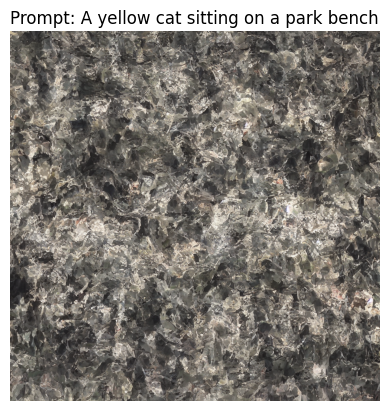

In [30]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Generar imagen
image_tensor = generate_sample_guidance(prompt, guidance_scale=1)

# Convertir el tensor a imagen PIL
image_pil = to_pil_image(image_tensor.squeeze(0))  # elimina la dimensión de batch

# Mostrar la imagen
plt.imshow(image_pil)
plt.axis("off")
plt.title(f"Prompt: {prompt}")
plt.show()


- ¿Qué desventaja tiene aumentar demasiado el factor de guidance?
> **Respuesta:**
- La técnica de classifier-free guidance también permite incluir prompts negativos en el proceso de generación. ¿Cómo se realiza esto?
> **Respuesta:**

In [31]:
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()

In [32]:
prompt = "A yellow cat sitting on a park bench"
generate_sample_guidance(prompt, guidance_scale=1)

tensor([[[[0.4774, 0.3209, 0.1478,  ..., 0.5371, 0.4781, 0.3758],
          [0.5060, 0.4437, 0.4474,  ..., 0.4965, 0.5938, 0.0984],
          [0.1807, 0.3754, 0.6609,  ..., 0.4222, 0.4033, 0.1329],
          ...,
          [0.6388, 0.4794, 0.9590,  ..., 0.0878, 0.1184, 0.0933],
          [0.7129, 0.6545, 0.9075,  ..., 0.1051, 0.0973, 0.0898],
          [0.8251, 0.6181, 0.7719,  ..., 0.0896, 0.0781, 0.1008]],

         [[0.4891, 0.3329, 0.0792,  ..., 0.5555, 0.4862, 0.3556],
          [0.5671, 0.4841, 0.4531,  ..., 0.4739, 0.6138, 0.0997],
          [0.1836, 0.4105, 0.7163,  ..., 0.4071, 0.4102, 0.1679],
          ...,
          [0.6497, 0.4450, 1.0000,  ..., 0.0834, 0.1342, 0.0802],
          [0.7483, 0.6135, 0.9318,  ..., 0.0887, 0.1034, 0.0924],
          [0.8295, 0.6076, 0.8021,  ..., 0.0712, 0.0698, 0.0635]],

         [[0.4896, 0.3971, 0.1684,  ..., 0.5378, 0.4921, 0.3465],
          [0.5841, 0.5565, 0.4857,  ..., 0.4814, 0.5139, 0.0705],
          [0.2450, 0.4295, 0.7766,  ..., 0

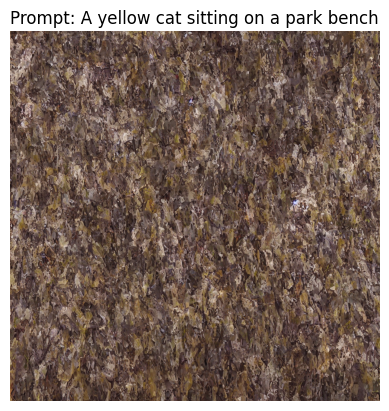

In [33]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Generar imagen
image_tensor = generate_sample_guidance(prompt, guidance_scale=1)

# Convertir el tensor a imagen PIL
image_pil = to_pil_image(image_tensor.squeeze(0))  # elimina la dimensión de batch

# Mostrar la imagen
plt.imshow(image_pil)
plt.axis("off")
plt.title(f"Prompt: {prompt}")
plt.show()

# ESTOS BLOQUES SON PARA ELIMINAR MEMORIA CARO, OSEA CUANDO TE SALE CUDA OUT OF MEMORY, ES COMO QUE REINICIA LA MEMORIA A CASI COMO SI SE REINICIARA EL ENTORNO DE FORMA RAPDIA

In [45]:
import torch
torch.cuda.empty_cache()

In [46]:
import gc
gc.collect()
torch.cuda.empty_cache()


## Parte 3: Inpainting

Una propiedad importante de los modelos de difusión es que permiten realizar la tarea de inpainting, la cual consiste en rellenar zonas de una imagen utilizando una máscara binaria, donde los pixeles blancos indican las zonas que deben ser rellenadas por el modelo de difusión.

Por lo general, para obtener un modelo de inpainting se suele realizar fine tuning sobre un modelo de difusión ya entrenado. Sin embargo, también es posible realizar esta técnica sustituyendo en cada iteración de denoising la parte no enmascarada de la imagen dada como input.

- Implemente la función `inpainting`, la cual recibe adicionalmente una imagen original y una máscara binaria para el inpainting.

# SUPUESTO CODIGO CORREGIDO

In [36]:
def inpainting(prompt, image, mask, guidance_scale):
    with torch.no_grad():
        # 1. Obtener embeddings del texto
        text_inputs = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
        context = text_encoder(**text_inputs).last_hidden_state  # [1,77,768]

        # 2. Codificar imagen original con el VAE
        image_tensor = to_tensor(image).unsqueeze(0).to(device) * 2 - 1  # Normalizar [-1,1]
        mask_tensor = to_tensor(mask).unsqueeze(0).to(device)

        latents = vae.encode(image_tensor).latent_dist.sample() * 0.18215
        noise = torch.randn_like(latents)

        # 3. Configurar scheduler
        scheduler.set_timesteps(50)
        timesteps = scheduler.timesteps

        # 4. Aplicar ruido inicial
        latent_input = scheduler.add_noise(latents, noise, timesteps[0])

        # Asegurar que la máscara tenga las mismas dimensiones que los latentes
        if mask_tensor.shape != latents.shape:
            mask_tensor = torch.nn.functional.interpolate(mask_tensor, size=latents.shape[-2:], mode='nearest')

        # 5. Loop de denoising
        for i, t in enumerate(timesteps):
            # Combinar latente original y el que será modificado
            latent_input_masked = latents * (1 - mask_tensor) + latent_input * mask_tensor

            # Predecir ruido con U-Net condicionada al texto
            noise_pred = unet(latent_input_masked, t, encoder_hidden_states=context).sample

            # Paso del scheduler (t debe ser int)
            latent_input = scheduler.step(noise_pred, t.item(), latent_input).prev_sample

        # 6. Decodificar latente final
        decoded = vae.decode(latent_input / 0.18215).sample
        image_final = (decoded.clamp(-1, 1) + 1) / 2  # Volver a [0,1]

    return image_final

In [ ]:
def inpainting(prompt, image, mask, guidance_scale):
    # 1. Obtener embeddings del texto usando CLIP
    text_inputs = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    context = text_encoder(**text_inputs).last_hidden_state  # [1,77,768]

    # 2. Codificar la imagen original con el VAE
    image_tensor = to_tensor(image).unsqueeze(0).to(device) * 2 - 1  # Normalizar [-1,1]
    mask_tensor = to_tensor(mask).unsqueeze(0).to(device)

    latents = vae.encode(image_tensor).latent_dist.sample() * 0.18215  # latente z_0
    noise = torch.randn_like(latents)

    # 3. Escoger timesteps
    scheduler.set_timesteps(50)  # puede ser DDIM o LMS
    timesteps = scheduler.timesteps

    # 4. Aplicar ruido inicial al latente
    latent_input = scheduler.add_noise(latents, noise, timesteps[0])

    # 5. Loop de denoising
    for i, t in enumerate(timesteps):
        # Combinar latente original y predicción: conservar fondo
        latent_input_masked = latents * (1 - mask_tensor) + latent_input * mask_tensor

        # Predecir ruido ε_t con la U-Net condicionada al texto
        noise_pred = unet(latent_input_masked, t, encoder_hidden_states=context).sample

        # Paso de scheduler
        latent_input = scheduler.step(noise_pred, t, latent_input).prev_sample

    # 6. Decodificar el latente final
    decoded = vae.decode(latent_input / 0.18215).sample
    image_final = (decoded.clamp(-1, 1) + 1) / 2
    return image_final

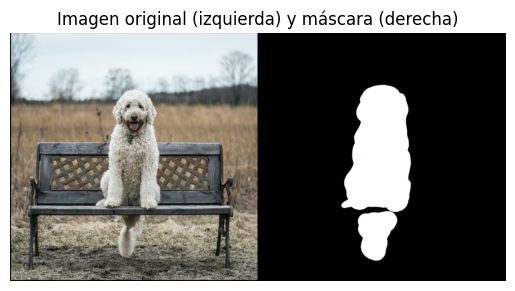

In [37]:
image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = load_image_from_url(image_url, mode="RGB")
mask = load_image_from_url(mask_url,  mode="L")

# Visualización de la imagen basal y máscara:
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image)
mask_tensor = to_tensor(mask)
mask_tensor = mask_tensor.expand(3, -1, -1)
grid = utils.make_grid([image_tensor, mask_tensor], nrow=2)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Imagen original (izquierda) y máscara (derecha)")
plt.show()

In [38]:
prompt = "A yellow cat sitting on a park bench"
inpainting(prompt, image, mask, guidance_scale=8)

tensor([[[[0.3356, 0.2600, 0.2223,  ..., 0.2638, 0.3646, 0.4556],
          [0.2761, 0.1788, 0.1422,  ..., 0.1465, 0.3283, 0.4323],
          [0.2476, 0.1518, 0.0880,  ..., 0.0385, 0.2679, 0.4145],
          ...,
          [0.8963, 1.0000, 1.0000,  ..., 0.1248, 0.1716, 0.2761],
          [0.8567, 1.0000, 1.0000,  ..., 0.1811, 0.2151, 0.3222],
          [0.7844, 0.9028, 0.9657,  ..., 0.2911, 0.3028, 0.3579]],

         [[0.2365, 0.1336, 0.0565,  ..., 0.3323, 0.4306, 0.4481],
          [0.1294, 0.0000, 0.0000,  ..., 0.2803, 0.4157, 0.4510],
          [0.0691, 0.0000, 0.0000,  ..., 0.2281, 0.3958, 0.4117],
          ...,
          [0.7735, 0.8284, 0.7877,  ..., 0.0794, 0.1363, 0.2460],
          [0.7572, 0.8160, 0.7720,  ..., 0.1150, 0.1642, 0.2663],
          [0.6735, 0.7440, 0.7057,  ..., 0.2142, 0.2568, 0.3347]],

         [[0.2052, 0.1372, 0.0823,  ..., 0.1644, 0.2335, 0.3226],
          [0.1100, 0.0254, 0.0000,  ..., 0.0278, 0.1492, 0.2748],
          [0.0401, 0.0000, 0.0000,  ..., 0